## Example:  Image Classification

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset consisting of images of articles of clothing. There are 60,000 examples in the training set and 10,000 examples in the test set. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Our goal in this example is to train a convolutional neural network that can classify an image as one of ten categories of clothing.

**Load the Data**

Load the data set into Python.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Fetch the data set
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:03<00:00, 7078631.86it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 376478.78it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 4760960.42it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



**Define the structure of the network**

Create a convolution neural network that subclasses `nn.Module`. The input features are the pixels of the image. The output is 1 of 10 class labels.

The first convolutional layer takes a 28x28 image with 1 color channel (grayscale) and outputs 8 channels (feature maps). The outputs are subsampled with a 2x2 max pooling layer.

The second convolutional layer takes 14x14 images with 8 channels and outputs 16 channels. Once again the outputs are subsampled with a 2x2 max pooling layer.

Classification is performed using 2 fully-connected layer. Essentially one hidden layer and one output layer. The 16 input features maps are flattened from 2D images and concatenated into a single 1D vector.

In [3]:
from torch import nn

class SimpleCNN(nn.Module):

  def __init__(self):
    # Call the initialization method of nn.Module
    super().__init__()

    # Define the structure of the network
    self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # 28x28 -> 14x14; 8 feature maps (Kernels), each Kernel is 3x3, 1 img @ input (since grayscale), 8 imgs @ output
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1) # 14x14 -> 7x7; 16 feature maps (take the previous 8 feature maps -output 'imgs' of the convolution- and outptus 16)
    self.pool = nn.MaxPool2d(2, 2)                          # 2x2 pooling, move 2 units (no overlap)
    #dividing the imag into 2x2 blocks; 4 pixels in the original would turn into 1 after applying the kernel: after 1st c.layer we get 14x14 and after the 2nd c.layer we get 7x7
    self.flatten = nn.Flatten()                             # 16 fm of 7x7 each -> 16 * 7 * 7 nodes
    self.fc = nn.Linear(16 * 7 * 7, 128)                    # fully connected layer w/ 128 nodes (hidden layer)
    self.output = nn.Linear(128, 10)                        # 10 output classes
    self.relu = nn.ReLU()                                   # activation function

  def forward(self, X):
    # Feature maps via convolutional layers
    # relu activation fcn. zeros out any -ve values coming out of the convolution
    X = self.pool(self.relu(self.conv1(X)))  # 28x28 -> 14x14 (8 images or fm each one is 14x14; the convlution outpts 8 fm 28x28 each, after the pooling it goes to 14x4 each)
    X = self.pool(self.relu(self.conv2(X))) # 14x14 -> 7x7    (after the convolution: 16 images or fm 14x14 each, after the pooling they become 7x7 each) 

    # Classification via fully connected layer
    X = self.flatten(X)  # transform 2D "images" into 1D vector
    X = self.relu(self.fc(X))
    X = self.output(X)

    return X

**Train and test the network**

To train the network, we need to choose a loss function in order to evaluate the performance of the network on the training data. For classification problems, `nn.CrossEntropyLoss` is a good choice.

We also need to validate the network against data from the test set in order to demonstrate that, among other issues, that the training process is not overfitting to the training data. Since the main block of code will use the validation process in a few locations, we create a helper function for looping over the test data.

In [5]:
def test(model, dataloader, loss_fn):
  # Store some information about the dataset
  size = len(dataloader.dataset)
  num_batches = len(dataloader)  # dataloader divides data set into batches

  # Validate the network on the images drawn from a test data set
  with torch.no_grad(): #no need for back propg. on the test data
    total_loss = correct = 0
    for X, y in dataloader:
      # Forward pass -- compute the predicted class using the network with the current set of weights
      y_pred = model(X)  # returns activation "energy" per class label

      # Compute the loss by comparing the predicted "energy" for each class to the actual class
      loss = loss_fn(y_pred, y)
      total_loss += loss.item()

      # Choose the label with highest activation
      labels = y_pred.argmax(1)  # choose the label with highest "energy"
      correct += (labels == y).sum().item()

  # Calculate and return some summary statistics
  accuracy = correct / size * 100  # percent correct predictions
  avg_loss = total_loss / num_batches

  return accuracy, avg_loss

Create an instance of the CNN. Setup the loss function and the optimizer. Repeat the train/test cycle for the predetermined number of epochs.

In [7]:
# Create an instance of the neural net
model = SimpleCNN()  # default of 128 nodes in the hidden layers

# Hyperparameters
LEARNING_RATE = .1
EPOCHS = 20
BATCH_SIZE = 64

# Choose a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()  # Loss function for classification problems
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Use a DataLoader to manage the random sampling and batching for SGD
training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Apply the network to the test set without any training
test_accuracy, test_loss = test(model, test_loader, loss_fn)

# Save some data for later analysis
batch_save_freq = 100

train_loss_data = [np.nan]

test_loss_data = [test_loss]
test_accuracy_data = [test_accuracy]

# Train the net for multiple epochs
print(f"Training Loop ({test_accuracy:>0.1f}% test accuracy at the start of training):\n")

train_size = len(training_loader.dataset)
batches_per_epoch = len(training_loader)  # batches created by data loader
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1:>2d} .", end="")

    # Train the network using batches of images drawn from training_loader
    total_loss = batch = 0
    for X, y in training_loader:  # X = batch of images, y = classes
      # Zero out any gradients from the previous iteration
      optimizer.zero_grad()

      # Forward pass -- compute the predicted class using the network with the current set of weights
      y_pred = model(X)  # forward propagation

      # Compute the loss by comparing the predicted "energy" for each class to the actual class
      loss = loss_fn(y_pred, y) 
      total_loss += loss.item()

      # Backpropagation -- calculate the gradient
      loss.backward()

      # Adjust the weights -- gradient descent
      optimizer.step()

      # Display progress
      if (batch % batch_save_freq == 0):
        print(".", end="")
      batch += 1

      # End of inner training loop

    # Calculate and store training statistics for the current epoch
    train_loss = total_loss / batches_per_epoch
    train_loss_data.append(train_loss)

    # Validate the network on the images drawn from test_loader
    test_accuracy, test_loss = test(model, test_loader, loss_fn)
    test_accuracy_data.append(test_accuracy)
    test_loss_data.append(test_loss)

    # Print a progress report for the current epoch
    print(f" Training loss = {train_loss:>1.4f} |",
          f"Test loss = {test_loss:>1.4f}, accuracy = {test_accuracy:>0.1f}%")

print("\nDone!")

Training Loop (10.0% test accuracy at the start of training):

Epoch  1 ........... Training loss = 0.7249 | Test loss = 0.4625, accuracy = 83.4%
Epoch  2 ........... Training loss = 0.4006 | Test loss = 0.3806, accuracy = 86.3%
Epoch  3 ........... Training loss = 0.3400 | Test loss = 0.3486, accuracy = 86.6%
Epoch  4 ........... Training loss = 0.3084 | Test loss = 0.3942, accuracy = 85.4%
Epoch  5 ........... Training loss = 0.2859 | Test loss = 0.3347, accuracy = 87.9%
Epoch  6 ........... Training loss = 0.2674 | Test loss = 0.2989, accuracy = 89.2%
Epoch  7 ........... Training loss = 0.2517 | Test loss = 0.3438, accuracy = 87.8%
Epoch  8 ........... Training loss = 0.2389 | Test loss = 0.3221, accuracy = 88.0%
Epoch  9 ........... Training loss = 0.2278 | Test loss = 0.2893, accuracy = 89.5%
Epoch 10 ........... Training loss = 0.2168 | Test loss = 0.2720, accuracy = 90.0%
Epoch 11 ........... Training loss = 0.2083 | Test loss = 0.3113, accuracy = 89.7%
Epoch 12 ........... Tra

**Loss and Accuracy Plots**

Unlike the previous examples, we cannot easily visualize the network's functionality. However, by graphing loss for both the training and test sets, we can get better sense of how the training process unfolded. One of the major concerns would be overfitting the network to the training data.

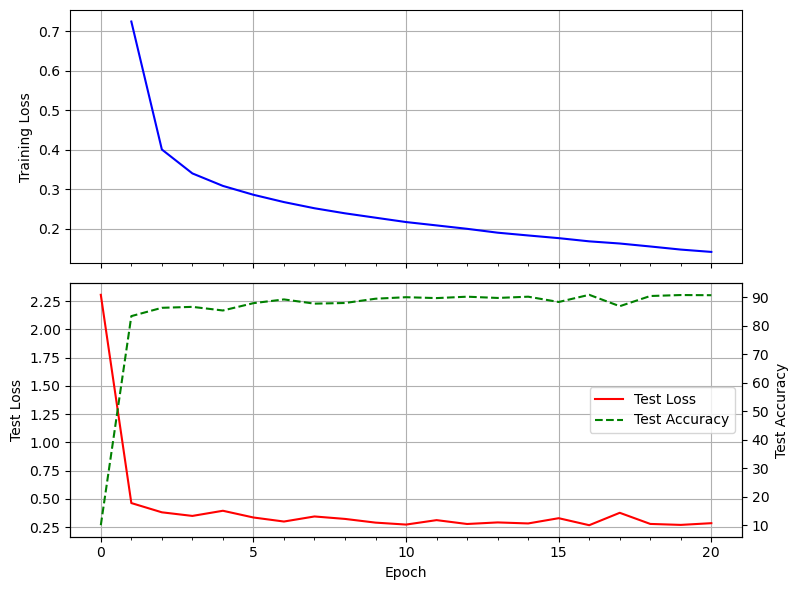

In [9]:
# X-axis data, ie epochs
xstart = 0 #change to 5 or  10 to change of where to start on the x-axis; a sort of zooming in!
xs = range(xstart, EPOCHS+1)

# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot the training loss on the first axis (ax1)
ax1.plot(xs, train_loss_data[xstart:], color='b')
ax1.set_ylabel('Training Loss')
ax1.grid(True)

# Plot the test loss on the second axis (ax2)
tlp, = ax2.plot(xs, test_loss_data[xstart:], color='r')
ax2.set_ylabel('Test Loss')
ax2.set_xlabel('Epoch')
ax2.set_xticks(range(xstart, EPOCHS+1, 5))
ax2.set_xticks(range(xstart, EPOCHS+1, 1), minor=True)
ax2.grid(True)

ax2a = ax2.twinx()
tap, = ax2a.plot(xs, test_accuracy_data[xstart:], color='g', linestyle="dashed")
ax2a.set_ylabel('Test Accuracy')
ax2.legend([tlp, tap], ["Test Loss", "Test Accuracy"], loc='center right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Plot the Confusion Matrix**

We can run a data set through a model to compare the model predictions to the correct labels. A *confusion matrix* highlights classes where the model may be struggling.

Number of predictions = 10000


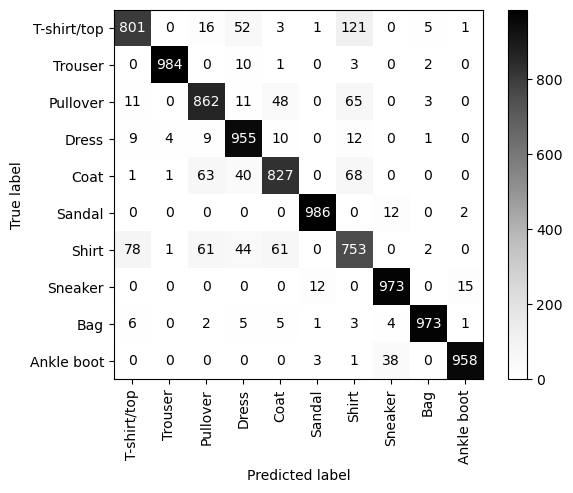

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_images = []
all_labels = []
fmnist_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Validate the network on all of the images drawn from the test set
with torch.no_grad():
  for images, labels in test_loader:
    all_images.append(images)
    all_labels.append(labels)

  # Concatenate the batches into a single tensor for images and labels
  all_images = torch.cat(all_images)
  all_labels = torch.cat(all_labels)

  predictions = model(all_images).argmax(1).numpy()  # choose the label with highest "energy"

print(f"Number of predictions = {len(predictions)}")

# Compute the confusion matrix, the diagonal represnts the correct matching answers
cm = confusion_matrix(all_labels, predictions)
ConfusionMatrixDisplay(cm, display_labels=fmnist_classes).plot(cmap="Greys", xticks_rotation="vertical")
plt.show()

**Visualize the Activation of Each Convolutional Layer**

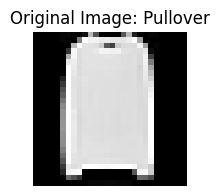

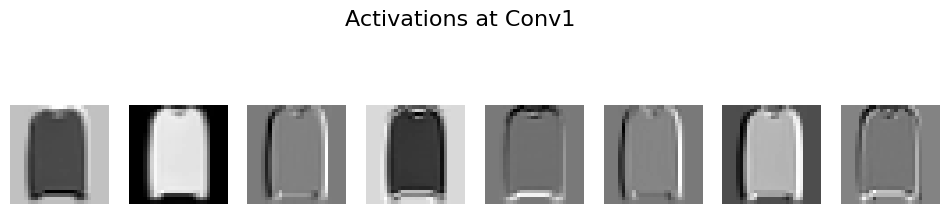

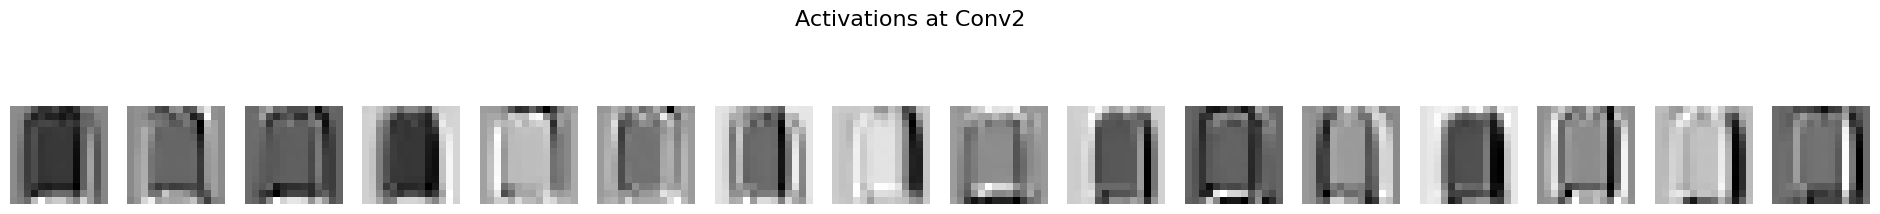

In [ ]:
# Create hooks to capture the output of each layer
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()  # Save the output to the dictionary
    return hook

# Register hooks for layers
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))

# Get a sample image and pass it through the network
rnd_idx = np.random.randint(len(training_loader.dataset))
image, label = training_loader.dataset[rnd_idx]
image = image.unsqueeze(0)  # Add a batch dimension

# Forward pass through the model
output = model(image)

# Show the original image
plt.figure(figsize=(2, 2))
plt.imshow(image[0][0].numpy(), cmap='gray')
plt.title(f"Original Image: {fmnist_classes[label]}")
plt.axis('off')

# Visualize the output at each layer
def plot_activations(activation_map, num_filters, layer_name):
    fig, axes = plt.subplots(1, num_filters, figsize=(num_filters * 1.5, 3))
    for i in range(num_filters):
        ax = axes[i]
        ax.imshow(activation_map[0, i].numpy(), cmap='gray')
        ax.axis('off')
    fig.suptitle(f'Activations at {layer_name}', fontsize=16)


# Plot the activations for conv1 and conv2
plot_activations(activation['conv1'], num_filters=8, layer_name='Conv1')
plot_activations(activation['conv2'], num_filters=16, layer_name='Conv2')

plt.show()